In [1]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# Change directory to the package folder 
%cd '/content/drive/MyDrive/dl-project'
# Verify the contents of the current folder 
!ls

/content/drive/MyDrive/dl-project
environment.yml     kaggle.json  README.md
img_embeddings.npy  main.py	 ResNet50Baseline.ipynb
kaggle		    modules	 shopee-product-matching


In [3]:
! pip install -q kaggle

In [16]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"pavponn","key":"530f7464381a375d7af4dde34d8f3ae0"}'}

In [17]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [18]:
! kaggle competitions download -c 'shopee-product-matching'

100% 1.68G/1.68G [01:21<00:00, 19.9MB/s]
100% 1.68G/1.68G [01:21<00:00, 22.3MB/s]


In [20]:
!unzip -q ./shopee-product-matching.zip -d ./shopee-product-matching/

replace ./shopee-product-matching/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [21]:
import numpy as np
import pandas as pd

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from modules.datasets.ImageShopeeDataset import ImageShopeeDataset
from modules.models.ResNet50EmbeddingsShopeeNet import ResNet50EmbeddingsShopeeNet
from modules.models.ResNet34EmbeddingsShopeeNet import ResNet34EmbeddingsShopeeNet
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
import os


In [34]:
DATA_FOLDER = './shopee-product-matching/'

IS_TEST = False

def get_dataset(root=DATA_FOLDER, is_test=False):
    name = "test.csv" if is_test else "train.csv"
    df = pd.read_csv(DATA_FOLDER + name)
    images_folder = "test_images/" if is_test else "train_images/"
    df['image'] = DATA_FOLDER + images_folder + df['image']
    return df

def add_target(df):
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    target = df['label_group'].map(grouped)
    new_df = df.copy()
    new_df['target'] = target
    return new_df



df = get_dataset(is_test=IS_TEST)
df = add_target(df)
df

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,./shopee-product-matching/train_images/0000a68...,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,./shopee-product-matching/train_images/0003978...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,./shopee-product-matching/train_images/000a190...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,./shopee-product-matching/train_images/00117e4...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,./shopee-product-matching/train_images/00136d1...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"
...,...,...,...,...,...,...
34245,train_4028265689,./shopee-product-matching/train_images/fff1c07...,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725,"[train_2829161572, train_4028265689]"
34246,train_769054909,./shopee-product-matching/train_images/fff4016...,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,"[train_1463059254, train_769054909]"
34247,train_614977732,./shopee-product-matching/train_images/fff421b...,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785,"[train_4126022211, train_3926241003, train_232..."
34248,train_3630949769,./shopee-product-matching/train_images/fff51b8...,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013,"[train_3419392575, train_1431563868, train_363..."


In [23]:
df[df['image'].apply(lambda x: os.path.exists(x))]

,posting_id,image,image_phash,title,label_group
0,train_129225211,./shopee-product-matching/train_images/0000a68...,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,./shopee-product-matching/train_images/0003978...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,./shopee-product-matching/train_images/000a190...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,./shopee-product-matching/train_images/00117e4...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,./shopee-product-matching/train_images/00136d1...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34245,train_4028265689,./shopee-product-matching/train_images/fff1c07...,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,./shopee-product-matching/train_images/fff4016...,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34247,train_614977732,./shopee-product-matching/train_images/fff421b...,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785
34248,train_3630949769,./shopee-product-matching/train_images/fff51b8...,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


In [24]:
images_dataset = ImageShopeeDataset(
    train['image'].values,
    transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

images_loader = torch.utils.data.DataLoader(
    images_dataset,
    batch_size=40,
    shuffle=False,
    num_workers=4
)

In [25]:
resnet18_emb_model = ResNet18EmbeddingsShopeeNet()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 28.0MB/s]


In [26]:
DEVICE = 'cuda'
resnet18_emb_model.to(DEVICE)

image_embeddings = []
with torch.no_grad():
    for data in tqdm(images_loader):
        data = data.to(DEVICE)
        embeddings = resnet18_emb_model(data)
        embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[1])
        embeddings = embeddings.data.cpu().numpy()
        image_embeddings.extend(embeddings)
        # if i == 5:
        #     break

# Just a check that outputs make sense
# image_embeddings[0:10]

100%|██████████| 857/857 [03:12<00:00,  4.46it/s]


In [27]:
image_embeddings = np.stack(image_embeddings)
norms = np.linalg.norm(image_embeddings, axis=1)
image_embeddings = image_embeddings / norms[:, np.newaxis]
image_embeddings.shape

(34250, 512)

In [28]:
np.save('./img_embeddings', image_embeddings)

In [29]:
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 2s (214 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd64.

In [30]:
k = 100
res = faiss.StandardGpuResources()
index_img = faiss.IndexFlatIP(512)
# index_img = faiss.index_cpu_to_gpu(res, 0, index_img)
index_img.add(image_embeddings)
similarities_img, indexes_img = index_img.search(image_embeddings, k)

In [42]:
def calc_f1_score(targets, results):
    intersect = len(np.intersect1d(targets, results))
    return 2 * intersect / (len(targets) + len(results))


def process_for_threshold(similarities, indexes, threshold):
    f1_score_accumulated = 0
    for i in range(len(image_embeddings)):
        cur_sims = similarities[i]
        cur_indexes = indexes[i]
        duplicate_indexes = cur_indexes[cur_sims >= threshold]
        results = df.iloc[duplicate_indexes]['posting_id'].values
        targets = df.iloc[i]['target']
        f1_score = calc_f1_score(targets, results)
        f1_score_accumulated += f1_score
    return f1_score_accumulated / len(image_embeddings)


thresholds = np.arange(0.85, 0.99, 0.01)
f1_avg_scores = []
for threshold in tqdm(thresholds):
    f1_avg = process_for_threshold(similarities_img, indexes_img, threshold)
    f1_avg_scores.append(f1_avg)

100%|██████████| 15/15 [03:11<00:00, 12.74s/it]


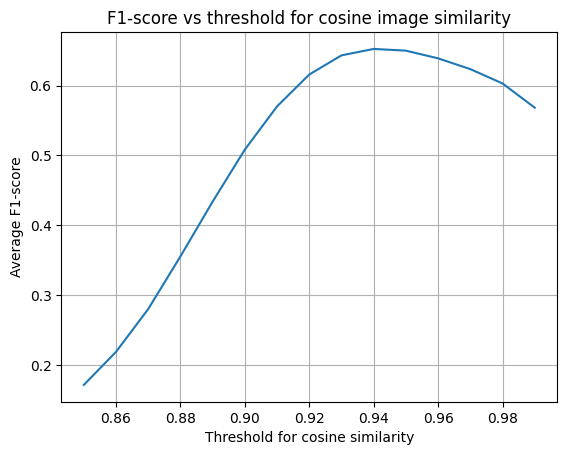

In [67]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_avg_scores)

# Add labels and title
plt.xlabel('Threshold for cosine similarity')
plt.ylabel('Average F1-score')
plt.title('F1-score vs threshold for cosine image similarity')
plt.grid(True)

max_f1 = max(f1_avg_scores)
max_threshold = thresholds[np.argmax(f1_avg_scores)]

# plt.annotate(f"{max_f1}", xy=(max_threshold, max_f1), xytext=(max_threshold, max_f1-0.05),
#              arrowprops=dict(facecolor='black', shrink=0.2), horizontalalignment = 'center')

# Save the plot to a file
plt.savefig('cnn-baseline-thresholds.png')

In [68]:
print(f"Max f1-score: {max_f1}, threshold: {max_threshold}") 

Max f1-score: 0.652468404162264, threshold: 0.9400000000000001
